#### Descripción
En la empresa en la cual te encuentras contratado, te solicitan trabajar con un registro de clientes de un banco e información sobre su salud financiera. La base contenida en el csv Credit abarca las siguientes variables:

- <code>Income:</code> Ingreso anual disponible en miles de dólares.
- <code>Limit:</code> Límite del crédito.
- <code>Rating:</code> Ranking del crédito.
- <code>Cards:</code> Cantidad de tarjetas de crédito.
- <code>Age:</code> Edad del usuario.
- <code>Education:</code> Años de educación del usuario.
- <code>Gender:</code> ¿Hombre o mujer?
- <code>Student:</code> ¿Es estudiante?
- <code>Married:</code> ¿Está casado?
- <code>Ethnicity:</code> Etnicidad del usuario (Caucásico, Afroamericano, Asiático)
- <code>Balance:</code> Promedio de deuda en tarjeta de crédito de usuario.

El objetivo que persigue el trabajo con esta base de datos es conocer los determinantes de la variación en el promedio de deuda en tarjeta de crédito. Para ello se te solicita generar modelos econométricos para inspeccionar los efectos de distintos atributos a partir de
requerimientos que serán detallados más adelante

#### 1. Preparar el ambiente de trabajo (1 puntos). Para ello debes:
- Importe las librerías básicas para el análisis de datos.
- Incluya los import base de statsmodels.
- Importe la base de datos <code>Credit.csv </code>y elimine la columna <code>Unnamed: 0</code>.
- Siguiendo las buenas prácticas, genere variables binarias para capturar el efecto del grupo minoritario en cada variable. Para el caso de Ethnicity, genere binarias para <code>African American, Caucasian y Asian</code>.
> Tip: Utilice value_counts() para revisar la cantidad de casos en las variables
categóricas

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings

from calidad_datos2 import *
from graficos import *

plt.style.use('seaborn') # Estilo de gráficos tipo seaborn
plt.rcParams["figure.figsize"] = (8,6) # Tamaño
plt.rcParams["figure.dpi"] = 70 # Resolución
warnings.filterwarnings('ignore')

df = pd.read_csv('Credit.csv',index_col=0) # asi no muestra la primera columna (Unmamed:0)
df.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
1,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
2,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
3,104.593,7075,514,4,71,11,Male,No,No,Asian,580
4,148.924,9504,681,3,36,11,Female,No,No,Asian,964
5,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


In [10]:
#Analisis de calidad del DataFrame
calidad = calidad_datos(df)
calidad

,tipo,nulos,porc_nulos,ceros,porc_ceros,count,unique,top,freq,mean,std,min,25%,50%,75%,max,dist_IQR,limit_inf,limit_sup,outliers
Limit,int64,0,0.0,0,0.000,400.0,NaN,NaN,NaN,4735.6,2308.198848,855.0,3088.0,4622.5,5872.75,13913.0,2784.75,-1089.125,10049.875,13
Rating,int64,0,0.0,0,0.000,400.0,NaN,NaN,NaN,354.94,154.724143,93.0,247.25,344.0,437.25,982.0,190.0,-37.75,722.25,11
Cards,int64,0,0.0,0,0.000,400.0,NaN,NaN,NaN,2.9575,1.371275,1.0,2.0,3.0,4.0,9.0,2.0,-1.0,7.0,2
Age,int64,0,0.0,0,0.000,400.0,NaN,NaN,NaN,55.6675,17.249807,23.0,41.75,56.0,70.0,98.0,28.25,-0.625,112.375,0
Education,int64,0,0.0,0,0.000,400.0,NaN,NaN,NaN,13.45,3.125207,5.0,11.0,14.0,16.0,20.0,5.0,3.5,23.5,0
Balance,int64,0,0.0,90,0.225,400.0,NaN,NaN,NaN,520.015,459.758877,0.0,68.75,459.5,863.0,1999.0,794.25,-1122.625,2054.375,0
Income,float64,0,0.0,0,0.000,400.0,NaN,NaN,NaN,45.218885,35.244273,10.354,21.00725,33.1155,57.47075,186.634,36.4635,-33.688,112.166,29
Gender,object,0,0.0,0,0.000,400,2,Female,207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
Student,object,0,0.0,0,0.000,400,2,No,360,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
Married,object,0,0.0,0,0.000,400,2,Yes,245,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


Gender
   Gender  Limit     Balance
0    Male    193  509.803109
1  Female    207  529.536232


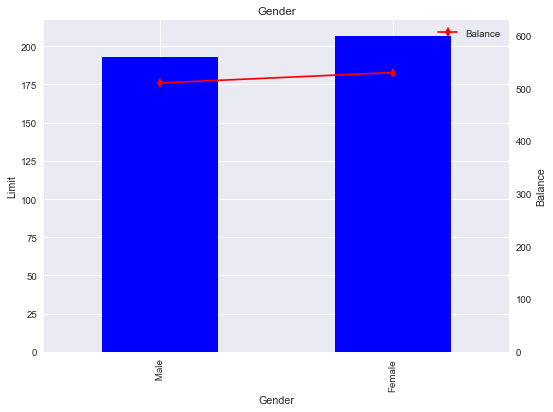

Student
  Student  Limit     Balance
0      No    360  480.369444
1     Yes     40  876.825000


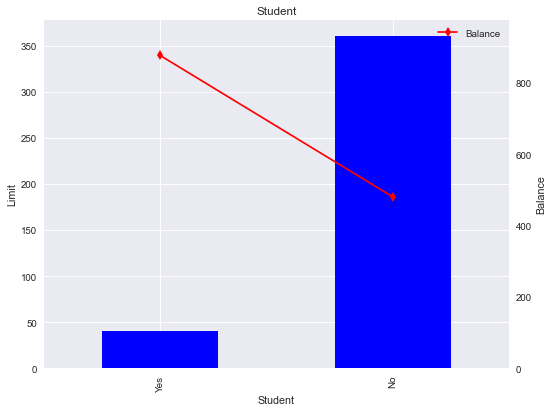

Married
  Married  Limit     Balance
0      No    155  523.290323
1     Yes    245  517.942857


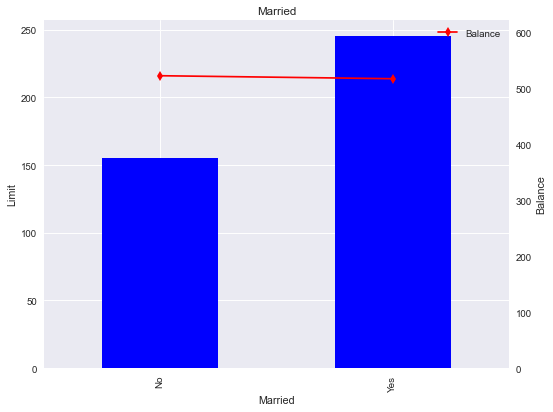

Ethnicity
          Ethnicity  Limit     Balance
0  African American     99  531.000000
1             Asian    102  512.313725
2         Caucasian    199  518.497487


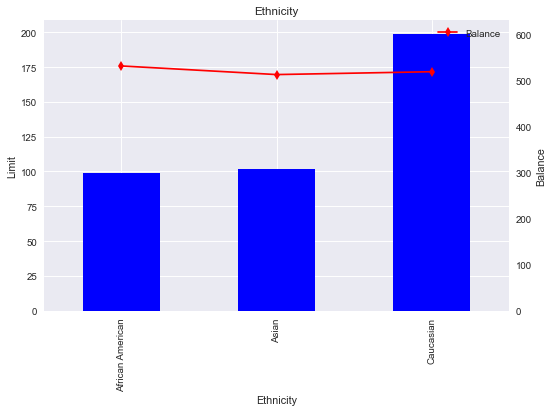

In [4]:
var_obj = 'Balance' #Variable Objetivo
for v in['Gender', 'Student', 'Married','Ethnicity']:
    print(v)
    g = df.groupby(v).agg({'Limit':'count', var_obj:'mean'}).reset_index()
    print(g)
    #sns.countplot(df[v])
    plt.show()
    cross_plot(g,'Limit', var_obj, v, size=(8,6), xlim=None, ylim=(0,g[var_obj].max()+100), titulo= v, order=1, medias=0)

In [18]:
f_dummies = pd.get_dummies(df, columns = ['Gender', 'Student', 'Ethnicity', 'Married'],
               dummy_na=False, prefix=None, prefix_sep='_', drop_first=False)
f_dummies

,Income,Limit,Rating,Cards,Age,Education,Balance,Gender_ Male,Gender_Female,Student_No,Student_Yes,Ethnicity_African American,Ethnicity_Asian,Ethnicity_Caucasian,Married_No,Married_Yes
1,14.891,3606,283,2,34,11,333,1,0,1,0,0,0,1,0,1
2,106.025,6645,483,3,82,15,903,0,1,0,1,0,1,0,0,1
3,104.593,7075,514,4,71,11,580,1,0,1,0,0,1,0,1,0
4,148.924,9504,681,3,36,11,964,0,1,1,0,0,1,0,1,0
5,55.882,4897,357,2,68,16,331,1,0,1,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,12.096,4100,307,3,32,13,560,1,0,1,0,0,0,1,0,1
397,13.364,3838,296,5,65,17,480,1,0,1,0,1,0,0,1,0
398,57.872,4171,321,5,67,12,138,0,1,1,0,0,0,1,0,1
399,37.728,2525,192,1,44,13,0,1,0,1,0,0,0,1,0,1


#### 2. Generar gráficos descriptivos para las variables continuas (1 puntos):
- Genere una función llamada plot_hist que genere un histograma de la variable e indique la media y mediana de la misma. Agregue una leyenda para indicar qué representa cada línea.
- ¿Cuál es el comportamiento de <code>Balance, Income, Cards y Rating</code>?

In [19]:
def plot_hist(df, variable, bins=100):
    tmp_mean = np.mean(df[variable])
    tmp_median = np.median(df[variable])
    plt.hist(df[variable], color='dodgerblue', alpha=.7, bins=bins)
    plt.axvline(tmp_mean, color='tomato', label="Media:{0}".format(round(tmp_mean, 1)))
    plt.axvline(tmp_median, color='#f2b41e', label="Mediana: {0}".format(round(tmp_median, 1)))
    plt.title("Histograma para {0}".format(variable))
    plt.legend()
    plt.show()

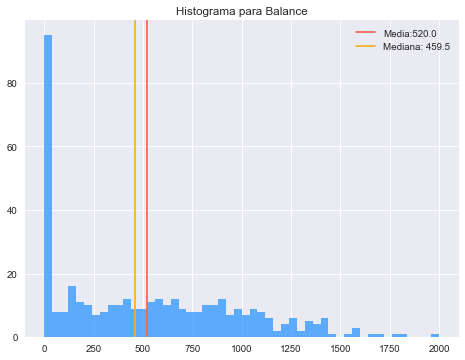

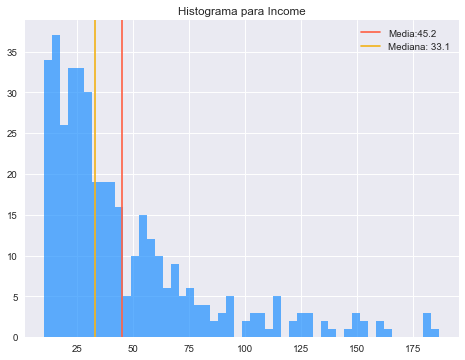

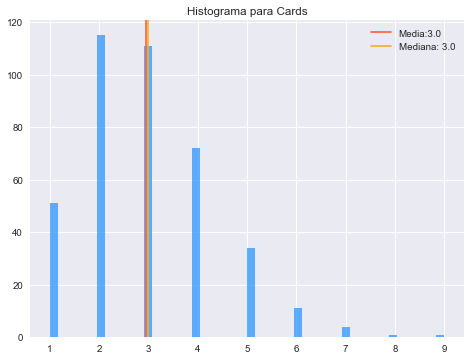

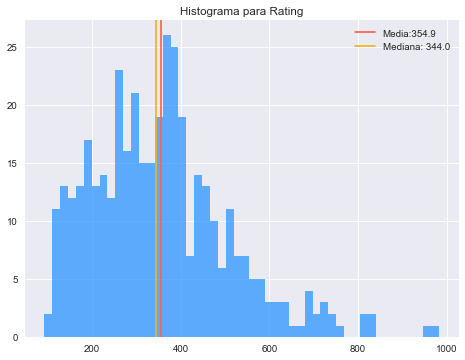

In [20]:
for v in ['Balance','Income','Cards','Rating']:
    plot_hist(df,v,bins=50)

#### 3. Regresión Lineal Simple (2 puntos). Para ello se debe:
- Generar una serie de modelos simples:
><code>𝐵𝑎𝑙𝑎𝑛𝑐𝑒 = β0 + γ · 𝑆𝑡𝑢𝑑𝑒𝑛𝑡 + ε</code>  
><code>𝐵𝑎𝑙𝑎𝑛𝑐𝑒 = β0 + β · 𝐼𝑛𝑐𝑜𝑚𝑒 + ε</code>  
><code>𝐵𝑎𝑙𝑎𝑛𝑐𝑒 = β0 + β · 𝑅𝑎𝑡𝑖𝑛𝑔 + ε</code>  

- Utilizando statsmodels, comente brevemente los siguientes puntos:
    - ¿Qué variable presenta un mayor poder explicativo de la variabilidad de Balance?
    > <code>Rating</code> ya que tiene una mayor progresion y mayor r2 por si sola 
    - ¿Qué podemos decir sobre el comportamiento de Student?
    > Que el ser o no estudiante afecta significativamente a Balance
    - ¿Qué pasa si aplicamos una prueba de hipótesis para muestras independientes de <code>Balance</code> entre aquellos que son y no son estudiantes?
    > Se rechaza la hipotesis nula

In [26]:
#ols=minimos cuadrados ordinarios

model_student = smf.ols('Balance ~ Student', df).fit() 
model_income = smf.ols('Balance ~ Income', df).fit()
model_rating = smf.ols('Balance ~ Rating', df).fit()

model_student.summary() # ver tabla con summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Balance   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     28.62
Date:                Sat, 11 Jun 2022   Prob (F-statistic):           1.49e-07
Time:                        16:46:24   Log-Likelihood:                -3005.5
No. Observations:                 400   AIC:                             6015.
Df Residuals:                     398   BIC:                             6023.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        480.3694     23.434     20.499      0.000     434.300     526.439
Student[T.Yes]   396.4556     74.104      5.350      0.000     250.771     542.140
==============================================================================
Omnibus:                       20.866   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.920
Skew:                           0.544   Prob(JB):                     1.74e-05
Kurtosis:                       2.637   Cond. No.                         3.37
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
model_income.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Balance   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     109.0
Date:                Sat, 11 Jun 2022   Prob (F-statistic):           1.03e-22
Time:                        16:45:52   Log-Likelihood:                -2970.9
No. Observations:                 400   AIC:                             5946.
Df Residuals:                     398   BIC:                             5954.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    246.5148     33.199      7.425      0.000     181.247     311.783
Income         6.0484      0.579     10.440      0.000       4.909       7.187
==============================================================================
Omnibus:                       42.505   Durbin-Watson:                   1.951
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.975
Skew:                           0.384   Prob(JB):                     2.79e-05
Kurtosis:                       2.182   Cond. No.                         93.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
model_rating.summary() # 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Balance   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     1168.
Date:                Sat, 11 Jun 2022   Prob (F-statistic):          1.90e-120
Time:                        16:46:28   Log-Likelihood:                -2745.4
No. Observations:                 400   AIC:                             5495.
Df Residuals:                     398   BIC:                             5503.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -390.8463     29.069    -13.446      0.000    -447.993    -333.699
Rating         2.5662      0.075     34.176      0.000       2.419       2.714
==============================================================================
Omnibus:                       23.223   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.802
Skew:                           0.390   Prob(JB):                     3.75e-09
Kurtosis:                       4.311   Cond. No.                         970.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
#Prueba hipotesis nula
student= df.loc[df.Student=='Yes'].Balance
no_student= df.loc[df.Student=='No'].Balance

stats.ttest_ind(student, no_student, equal_var=True) # y se rechaza 


Ttest_indResult(statistic=5.349964123075003, pvalue=1.487734107732302e-07)

#### 4. Generar un modelo que incluya todos los regresores (2 puntos):
A partir de la siguiente fórmula, genere el modelo que incluya dichos regresores y comente brevemente sobre el poder explicativo en la varianza de <code>𝑦</code> y las principales características de los predictores.  

![Formula](formula1.PNG)

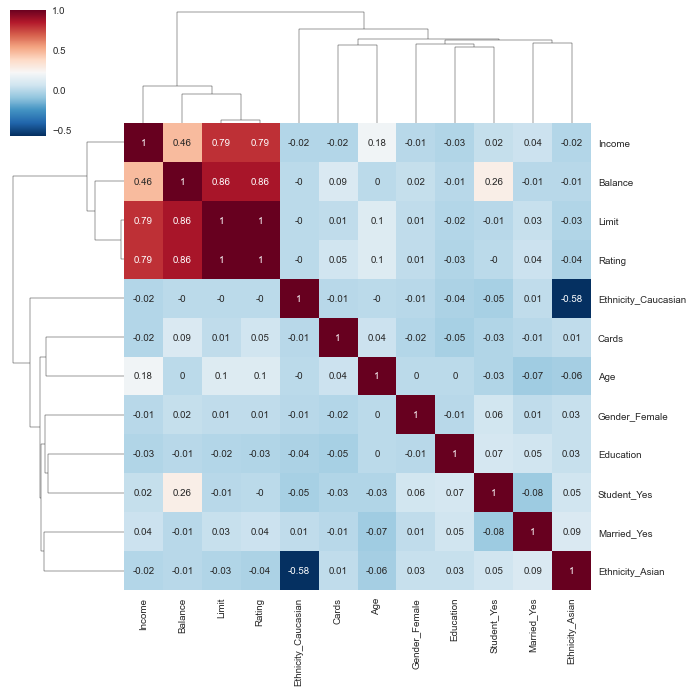

In [40]:
cor = pd.get_dummies(df,drop_first=True).corr().round(2)
sns.clustermap(cor,cmap='RdBu_r', annot=True)

In [39]:
model_1 = smf.ols('Balance ~ Income + Limit + Rating + Cards + Age + Education + Gender + Student + Married + Ethnicity', df).fit()
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Balance   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     750.3
Date:                Sat, 11 Jun 2022   Prob (F-statistic):          1.11e-253
Time:                        17:02:00   Log-Likelihood:                -2398.7
No. Observations:                 400   AIC:                             4821.
Df Residuals:                     388   BIC:                             4869.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               -479.2079     35.774    -13.395      0.000    -549.543    -408.873
Gender[T.Female]         -10.6532      9.914     -1.075      0.283     -30.145       8.839
Student[T.Yes]           425.7474     16.723     25.459      0.000     392.869     458.626
Married[T.Yes]            -8.5339     10.363     -0.824      0.411     -28.908      11.841
Ethnicity[T.Asian]        16.8042     14.119      1.190      0.235     -10.955      44.564
Ethnicity[T.Caucasian]    10.1070     12.210      0.828      0.408     -13.899      34.113
Income                    -7.8031      0.234    -33.314      0.000      -8.264      -7.343
Limit                      0.1909      0.033      5.824      0.000       0.126       0.255
Rating                     1.1365      0.491      2.315      0.021       0.171       2.102
Cards                     17.7245      4.341      4.083      0.000       9.190      26.259
Age                       -0.6139      0.294     -2.088      0.037      -1.192      -0.036
Education                 -1.0989      1.598     -0.688      0.492      -4.241       2.043
==============================================================================
Omnibus:                       34.899   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.766
Skew:                           0.782   Prob(JB):                     8.52e-10
Kurtosis:                       3.241   Cond. No.                     3.87e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.87e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### 5. Depurar el modelo e incluya sólo los predictores significativo (2 puntos)
- En base al modelo anterior, refactoriza e incluya sólo las variables con un nivel de significancia 𝑝 − 𝑣𝑎𝑙𝑢𝑒 ≤. 025. Comente brevemente sobre el poder explicativo en la varianza de <code>𝑦</code> y las principales características de los predictores.
- ¿Mejoró o empeoró el modelo con la reducción de regresores?
> NO se ve afectado al sacar variables que no son tan importantes

In [41]:
model_2 = smf.ols('Balance ~ Income + Limit + Rating + Cards + Age + Student ', df).fit()
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Balance   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     1380.
Date:                Sat, 11 Jun 2022   Prob (F-statistic):          1.58e-260
Time:                        17:08:53   Log-Likelihood:                -2400.5
No. Observations:                 400   AIC:                             4815.
Df Residuals:                     393   BIC:                             4843.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       -493.7342     24.825    -19.889      0.000    -542.540    -444.928
Student[T.Yes]   425.6099     16.510     25.780      0.000     393.152     458.068
Income            -7.7951      0.233    -33.395      0.000      -8.254      -7.336
Limit              0.1937      0.032      5.981      0.000       0.130       0.257
Rating             1.0912      0.485      2.251      0.025       0.138       2.044
Cards             18.2119      4.319      4.217      0.000       9.721      26.702
Age               -0.6241      0.292     -2.139      0.033      -1.198      -0.050
==============================================================================
Omnibus:                       34.091   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.623
Skew:                           0.772   Prob(JB):                     1.51e-09
Kurtosis:                       3.225   Cond. No.                     2.66e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.66e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### 6. Utilizando <code>lmplot</code> de <code>seaborn</code>, inspeccione el comportamiento de los tres principales determinantes. (2 puntos)

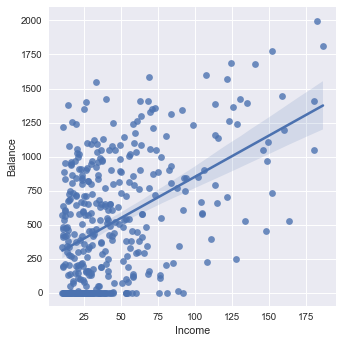

In [42]:
sns.lmplot(data=df, x='Income', y='Balance')

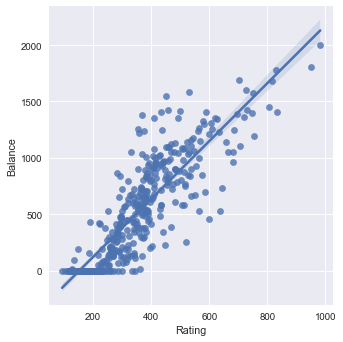

In [43]:
sns.lmplot(data=df, x='Rating', y='Balance')

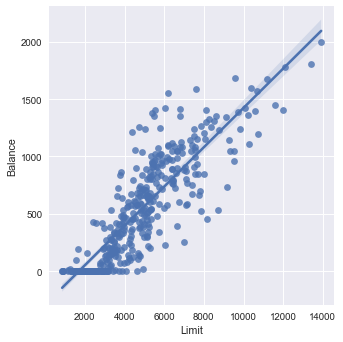

In [44]:
sns.lmplot(data=df, x='Limit', y='Balance')

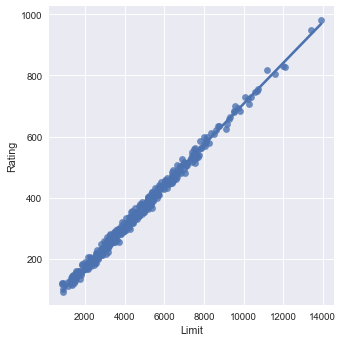

In [45]:
sns.lmplot(data=df, x='Limit', y='Rating')